In [1]:
# a dimensionality reduction technique
!pip install datasets umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=3c1a44b29d1047a6ed8f86ec862558abdc3168d1de497fd68110dd933e04cbbd
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 

In [29]:
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from umap import UMAP
from sklearn.cluster import KMeans

In [22]:
#@title load dataset
dataset = load_dataset("SetFit/bbc-news")
train = pd.DataFrame({"text": dataset["train"]["text"]})
train.head(3)

Repo card metadata block was not found. Setting CardData to empty.


,text
0,wales want rugby league training wales could f...
1,china aviation seeks rescue deal scandal-hit j...
2,rock band u2 break ticket record u2 have smash...


In [25]:
#@title text -> embeddings
tfidf = TfidfVectorizer(stop_words="english", binary=True, max_features=25_000)
text_embeddings = tfidf.fit_transform(train["text"]).toarray()
print(text_embeddings.shape)
text_embeddings[:3]

(1225, 22705)


array([[0.        , 0.05230575, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05468187, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
#@title reduce dimensionality
umap = UMAP()
twod_embeddings = umap.fit_transform(text_embeddings)
print(twod_embeddings.shape)
twod_embeddings[:3]

(1225, 2)


array([[-1.2696747,  9.286327 ],
       [11.112213 ,  8.600309 ],
       [ 5.848897 ,  7.0044312]], dtype=float32)

In [30]:
#@title clustering

kmeans = KMeans(n_clusters=5)
kmeans.fit(twod_embeddings)
train["cluster"] = kmeans.labels_
train.head(3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,text,cluster
0,wales want rugby league training wales could f...,2
1,china aviation seeks rescue deal scandal-hit j...,1
2,rock band u2 break ticket record u2 have smash...,0


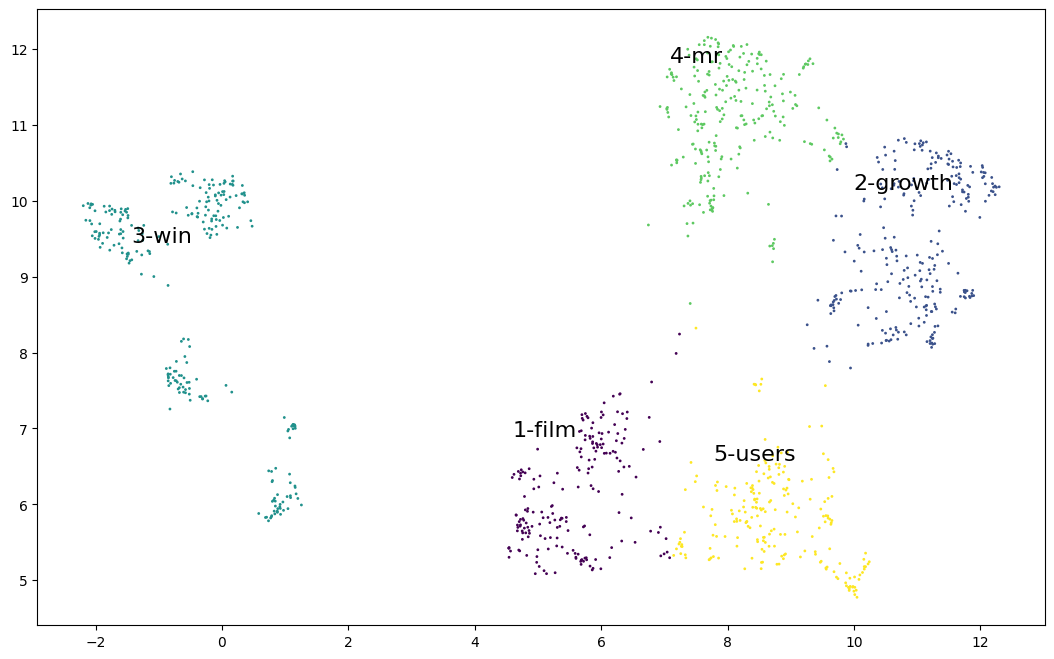

In [35]:
#@title plot

centers = kmeans.cluster_centers_

plt.figure(figsize=(13, 8))
plt.scatter(twod_embeddings[:,0], twod_embeddings[:,1], s=1, c=kmeans.labels_)

for k in range(len(centers)):
    mm = np.mean(text_embeddings[train.cluster.values==k],axis=0)
    ii = np.argmax(mm)
    top_word = list(tfidf.vocabulary_.keys())[list(tfidf.vocabulary_.values()).index(ii)]
    plt.text(centers[k,0]-1,centers[k,1]+0.75,f'{k+1}-{top_word}',size=16)